In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile
from tensorflow.python.framework import ops

In [3]:
sess = tf.Session()

In [4]:
epochs = 300
batch_size = 250
max_sequence_length = 25
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0001
dropout_keep_prob = tf.placeholder(tf.float32)

In [5]:
data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [6]:
if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')

    
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    
    text_data = []
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data.append(row)
    text_data = text_data[:-1]

In [7]:
text_data = [x.split('\t') for x in text_data if len(x)>=1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

In [8]:
def clean_text(text_string):
 text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
 text_string = " ".join(text_string.split())
 text_string = text_string.lower()
 return(text_string)

In [9]:
text_data_train = [clean_text(x) for x in text_data_train]

In [10]:
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length, min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [11]:
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x=='ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

In [12]:
ix_cutoff = int(len(y_shuffled)*0.75)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.vocabulary_)
print("Vocabulary size: {:d}".format(vocab_size))
print("Training set size: {:d}".format(len(y_train)))
print("Test set size: {:d}".format(len(y_test)))

Vocabulary size: 933
Training set size: 4180
Test set size: 1394


In [13]:
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

In [14]:
embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

In [15]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units = rnn_size)
output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)

In [16]:
weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.nn.softmax(tf.matmul(last, weight) + bias)

In [17]:
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output)
loss = tf.reduce_mean(losses)

In [18]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))

In [19]:
optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

In [20]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [21]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

In [22]:
for epoch in range(epochs):
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train)/batch_size) + 1

    for i in range(num_batches):
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i+1) * batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]

        train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
        sess.run(train_step, feed_dict=train_dict)

    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)

    test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))

print('\nOverall accuracy on test set (%): {}'.format(np.mean(temp_test_acc)*100.0))  


Epoch: 1, Test Loss: 0.7, Test Acc: 0.18
Epoch: 2, Test Loss: 0.7, Test Acc: 0.18
Epoch: 3, Test Loss: 0.69, Test Acc: 0.81
Epoch: 4, Test Loss: 0.69, Test Acc: 0.82
Epoch: 5, Test Loss: 0.68, Test Acc: 0.82
Epoch: 6, Test Loss: 0.67, Test Acc: 0.82
Epoch: 7, Test Loss: 0.66, Test Acc: 0.82
Epoch: 8, Test Loss: 0.65, Test Acc: 0.82
Epoch: 9, Test Loss: 0.65, Test Acc: 0.82
Epoch: 10, Test Loss: 0.64, Test Acc: 0.82
Epoch: 11, Test Loss: 0.63, Test Acc: 0.83
Epoch: 12, Test Loss: 0.62, Test Acc: 0.83
Epoch: 13, Test Loss: 0.61, Test Acc: 0.83
Epoch: 14, Test Loss: 0.61, Test Acc: 0.83
Epoch: 15, Test Loss: 0.6, Test Acc: 0.83
Epoch: 16, Test Loss: 0.59, Test Acc: 0.83
Epoch: 17, Test Loss: 0.59, Test Acc: 0.84
Epoch: 18, Test Loss: 0.58, Test Acc: 0.84
Epoch: 19, Test Loss: 0.58, Test Acc: 0.84
Epoch: 20, Test Loss: 0.57, Test Acc: 0.84
Epoch: 21, Test Loss: 0.57, Test Acc: 0.84
Epoch: 22, Test Loss: 0.56, Test Acc: 0.84
Epoch: 23, Test Loss: 0.56, Test Acc: 0.84
Epoch: 24, Test Loss: 0

Epoch: 190, Test Loss: 0.43, Test Acc: 0.88
Epoch: 191, Test Loss: 0.43, Test Acc: 0.88
Epoch: 192, Test Loss: 0.43, Test Acc: 0.88
Epoch: 193, Test Loss: 0.43, Test Acc: 0.88
Epoch: 194, Test Loss: 0.43, Test Acc: 0.88
Epoch: 195, Test Loss: 0.43, Test Acc: 0.88
Epoch: 196, Test Loss: 0.43, Test Acc: 0.88
Epoch: 197, Test Loss: 0.43, Test Acc: 0.88
Epoch: 198, Test Loss: 0.43, Test Acc: 0.88
Epoch: 199, Test Loss: 0.43, Test Acc: 0.88
Epoch: 200, Test Loss: 0.43, Test Acc: 0.88
Epoch: 201, Test Loss: 0.43, Test Acc: 0.88
Epoch: 202, Test Loss: 0.43, Test Acc: 0.88
Epoch: 203, Test Loss: 0.43, Test Acc: 0.88
Epoch: 204, Test Loss: 0.43, Test Acc: 0.88
Epoch: 205, Test Loss: 0.43, Test Acc: 0.88
Epoch: 206, Test Loss: 0.43, Test Acc: 0.88
Epoch: 207, Test Loss: 0.43, Test Acc: 0.88
Epoch: 208, Test Loss: 0.43, Test Acc: 0.88
Epoch: 209, Test Loss: 0.43, Test Acc: 0.88
Epoch: 210, Test Loss: 0.43, Test Acc: 0.88
Epoch: 211, Test Loss: 0.43, Test Acc: 0.88
Epoch: 212, Test Loss: 0.43, Tes

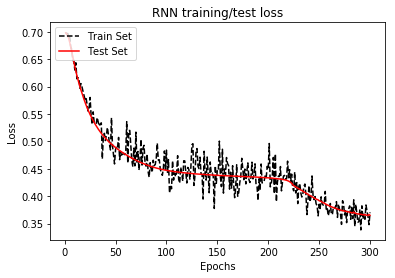

In [23]:
epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('RNN training/test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

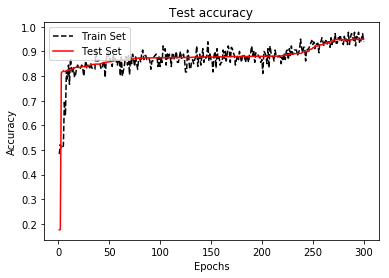

In [24]:
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()